<a href="https://colab.research.google.com/github/dushyant3615/Movie_analysis/blob/main/imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


MSE: 0.0349
MAE: 0.1508
R2: 0.4561


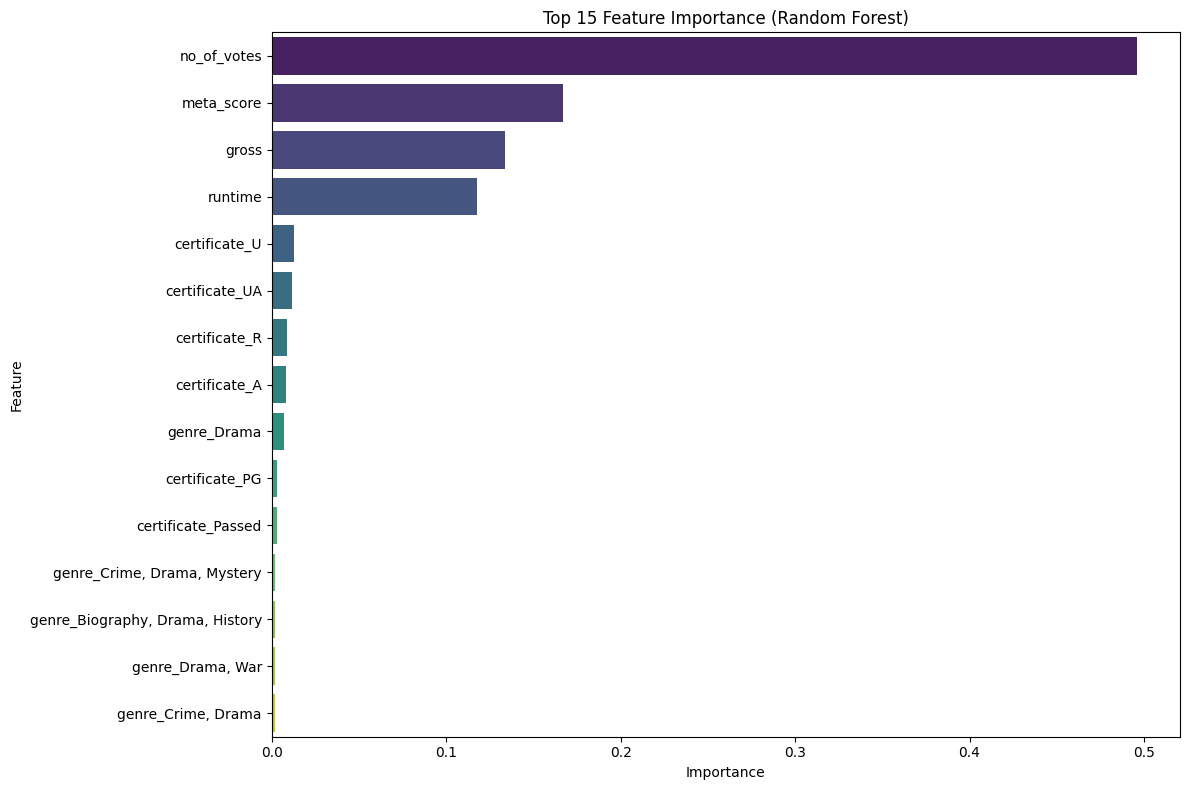

In [2]:
from __future__ import annotations
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Robust path handling for local and Colab
possible_paths = [
    "./imdb_top_1000.csv",
    "imdb_top_1000.csv",
    "/content/imdb_top_1000.csv",
]
for candidate in possible_paths:
    if os.path.exists(candidate):
        data_path = candidate
        break
else:
    raise FileNotFoundError("imdb_top_1000.csv not found. Place it next to the notebook.")

# Load the dataset
data = pd.read_csv(data_path)

# Normalize column names
data.columns = data.columns.str.strip().str.lower()

# Standardize numeric-like text columns before modeling
if 'gross' in data:
    data['gross'] = (
        data['gross']
        .astype(str)
        .str.replace(',', '', regex=True)
    )
if 'no_of_votes' in data:
    data['no_of_votes'] = (
        data['no_of_votes']
        .astype(str)
        .str.replace(',', '', regex=True)
    )
if 'runtime' in data:
    data['runtime'] = (
        data['runtime']
        .astype(str)
        .str.replace(' min', '', regex=False)
    )

# Target and candidate features
target_col = 'imdb_rating'
# Keep simple subset to avoid exploding sparsity and overfit on small data
categorical_cols = [c for c in ['genre', 'certificate'] if c in data.columns]
numeric_cols = [c for c in ['runtime', 'gross', 'no_of_votes', 'meta_score'] if c in data.columns]

# Drop rows with missing target
data = data.dropna(subset=[target_col])

X = data[categorical_cols + numeric_cols]
y = data[target_col]

# Preprocess: impute + encode/convert types
numeric_transformer = Pipeline(steps=[
    ("to_float", FunctionTransformer(lambda df: pd.DataFrame(
        {col: pd.to_numeric(df[col], errors='coerce') for col in df.columns}
    ), feature_names_out='one-to-one', validate=False)),
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder='drop',
)

model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    max_depth=None,
    min_samples_leaf=2,
)

pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model),
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.4f}\nMAE: {mae:.4f}\nR2: {r2:.4f}")

# Extract feature names after preprocessing for importances
rf = pipeline.named_steps["model"]
ct: ColumnTransformer = pipeline.named_steps["preprocess"]

numeric_feature_names = numeric_cols
cat_feature_names = []
if categorical_cols:
    enc: OneHotEncoder = ct.named_transformers_["cat"].named_steps["encoder"]
    # get_feature_names_out requires numpy array of input feature names
    cat_feature_names = enc.get_feature_names_out(categorical_cols).tolist()

all_feature_names = numeric_feature_names + cat_feature_names
importances = rf.feature_importances_

feat_imp = (
    pd.DataFrame({"Feature": all_feature_names, "Importance": importances})
    .sort_values("Importance", ascending=False)
)

# Plot top-k
top_k = 15
plt.figure(figsize=(12, 8))
sns.barplot(
    data=feat_imp.head(top_k),
    x="Importance",
    y="Feature",
    hue="Feature",
    dodge=False,
    palette="viridis",
    legend=False,
)
plt.title(f"Top {top_k} Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

In [3]:
import os
from datetime import datetime

# Ensure output directory exists (use project root by default)
output_dir = '.'
os.makedirs(output_dir, exist_ok=True)

# 1) Save feature importance plot (recompute lightweightly if needed)
try:
    # If feat_imp exists from previous cell, reuse it
    assert 'feat_imp' in globals()
except AssertionError:
    # Recompute importances from the fitted pipeline
    rf = pipeline.named_steps['model']
    ct = pipeline.named_steps['preprocess']
    numeric_feature_names = [c for c in ['runtime','gross','no_of_votes','meta_score'] if c in X.columns]
    cat_feature_names = []
    if [c for c in ['genre','certificate'] if c in X.columns]:
        enc = ct.named_transformers_['cat'].named_steps['encoder']
        cat_feature_names = enc.get_feature_names_out([c for c in ['genre','certificate'] if c in X.columns]).tolist()
    all_feature_names = numeric_feature_names + cat_feature_names
    importances = rf.feature_importances_
    feat_imp = (
        pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
        .sort_values('Importance', ascending=False)
    )

plt.figure(figsize=(12, 8))
sns.barplot(data=feat_imp.head(15), x='Importance', y='Feature', hue='Feature', dodge=False, palette='viridis', legend=False)
plt.title('Top 15 Feature Importance (Random Forest)')
plt.tight_layout()
fi_path = os.path.join(output_dir, 'feature_importance.png')
plt.savefig(fi_path, dpi=200, bbox_inches='tight')
plt.close()

# 2) Save predictions vs actual scatter
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
plt.figure(figsize=(7,7))
sns.scatterplot(data=pred_df, x='Actual', y='Predicted', s=30, alpha=0.7)
lims = [min(pred_df.min().min(), 0), max(pred_df.max().max(), 10)]
plt.plot(lims, lims, 'r--', linewidth=1)
plt.xlim(lims)
plt.ylim(lims)
plt.title('Predicted vs Actual IMDb Rating')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
pa_path = os.path.join(output_dir, 'predicted_vs_actual.png')
plt.savefig(pa_path, dpi=200, bbox_inches='tight')
plt.close()

print(f"Saved: {fi_path}\nSaved: {pa_path}")


Saved: .\feature_importance.png
Saved: .\predicted_vs_actual.png
